## Allowing import from parent's directory

In [69]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

## Importing the required modules

In [59]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
import tools.loaddata as loaddata
import tools.dataassimilation as da

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

## Summary of findings

In this notebook, we perform 5 experiments in order to select the best <b>B</b> and <b>R</b> matrices. The experiment includes:



- <b>Experiment 1:</b> R = cov_compress, B = I and vary magnitude of B
- <b>Experiment 2:</b> R = B = cov_compress and vary the coefficient of B
- <b>Experiment 3:</b> R = cov_compress and B = cov_compress_diag, vary B
- <b>Experiment 4:</b> R = cov_compress_diag and B = I and vary R instead
- <b>Experiment 5:</b> R = B cov_compress_diag vary B¶

Note:

<b>cov_compress</b> = covariance matrix of the compressed data<br>
<b>I</b> = identity<br>
<b>cov_compress_diag</b> = covariance matrix of the compressed data, but entries not on the diagonal are 0<br>

It turns out experiment 5, is the best performing one, and we are able to reduce the MSE for PCA data assimilation from around 0.07 to 0.05:

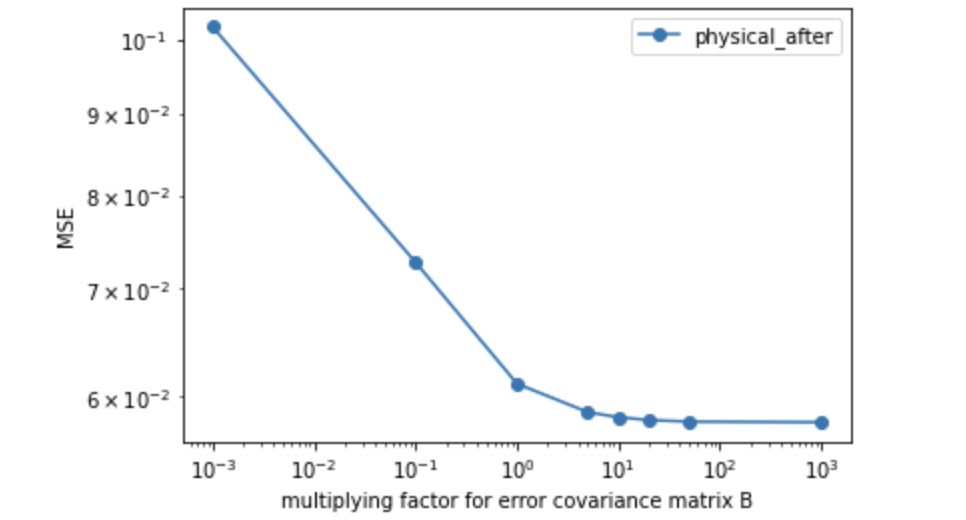

## Loading and reshaping data

In [62]:
path_train = "../data/train/"
path_test = "../data/test/"
path_back = "../data/background/"
path_obs = "../data/satellite/"

In [63]:
train_full, test, model_data, satellite_data = loaddata.load_all_data(path_train, path_test, path_back, path_obs)

In [64]:
train = train_full[0:300]

In [65]:
print(f"Train data before reshaping: {np.shape(train)}")
print(f"Test data before reshaping: {np.shape(test)}")
print(f"background data before reshaping: {np.shape(model_data)}")
print(f"observational data before reshaping: {np.shape(satellite_data)}")

Train data before reshaping: (300, 871, 913)
Test data before reshaping: (300, 871, 913)
background data before reshaping: (5, 871, 913)
observational data before reshaping: (5, 871, 913)


In [67]:
train_1D, test_1D, model_data_1D, satellite_data_1D = loaddata.reshape_all_datasets(train, test, model_data, satellite_data)

In [68]:
print(f"Train data after reshaping: {train_1D.shape}")
print(f"Test data after reshaping: {test_1D.shape}")
print(f"Model data after reshaping: {model_data_1D.shape}")
print(f"Observational data after reshaping: {satellite_data_1D.shape}")

Train data after reshaping: (300, 795223)
Test data after reshaping: (300, 795223)
Model data after reshaping: (5, 795223)
Observational data after reshaping: (5, 795223)


## Fitting PCA once

In [9]:
## Fitting PCA
pca = PCA(min(train_1D.shape))
pca.fit(train_1D)

## Choosing p of 0.99
p = 0.99
cumsum_eig = np.cumsum(pca.explained_variance_ratio_)
k = np.argmax(cumsum_eig >= p) + 1 # k is the number of principal components we have chosen
print(f'{k} features is required to explain {p*100}% of the variance.')

## Training compressed PCA
pca_compress = PCA(n_components=k)
pca_compress.fit(train_1D)

195 features is required to explain 99.0% of the variance.


PCA(n_components=195)

In [10]:
## Compressing data with pca
model_data_compr = pca_compress.transform(model_data_1D)
satellite_data_compr = pca_compress.transform(satellite_data_1D)

In [11]:
def data_assim_experiment(val, I, H, R, B, latent_space):
    mse_physical_before = []
    mse_physical_after = []
    mse_latent_before = []
    mse_latent_after = []
    for j in val:
        updated_data_array = da.assimilate(B*j, H, R, model_data_compr, satellite_data_compr)

        mse_before_DA = da.mse(satellite_data_compr, model_data_compr)
        mse_after_DA = da.mse(satellite_data_compr, updated_data_array)
        mse_latent_before.append(mse_before_DA)
        mse_latent_after.append(mse_after_DA)

        updated_data_recon = pca_compress.inverse_transform(updated_data_array)
        mse_before_DA_physical = da.mse(satellite_data_1D, model_data_1D)
        mse_after_DA_physical = da.mse(satellite_data_1D, updated_data_recon)
        mse_physical_before.append(mse_before_DA_physical)
        mse_physical_after.append(mse_after_DA_physical)

        print("B: ", j,"mse_l_bef: ", mse_before_DA, "mse_l_af: ",mse_after_DA,"\n", "mse_p_bef: ", mse_before_DA_physical, "mse_p_af: ", mse_after_DA_physical)
    return mse_physical_before, mse_physical_after, mse_latent_before, mse_latent_after

## Experiment 1: Try R as compressed data, B is identity and vary magnitude of B

In [27]:
# Data Assimilation - Kalman Filter (BLUE)

latent_space = k
nNodes = latent_space  # latent_space is the size of the compressed variables or number of principal components used
I = np.identity(nNodes)
H = I 

In [41]:
# Initial set up
R = np.cov(satellite_data_compr.T)
B = I

val = [0.00001, 0.001, 0.1, 1, 5, 10, 100, 1000, 10000, 20000, 400000, 9999999]
mse_physical_before, mse_physical_after, mse_latent_before, mse_latent_after = data_assim_experiment(val, I, H, R, B, latent_space)
    

B:  1e-05 mse_l_bef:  187.19478449101607 mse_l_af:  25.751095665636676 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06412791657482658
B:  0.001 mse_l_bef:  187.19478449101607 mse_l_af:  25.750927644514697 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06412787537365565
B:  0.1 mse_l_bef:  187.19478449101607 mse_l_af:  25.734151035524988 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.0641237615103079
B:  1 mse_l_bef:  187.19478449101607 mse_l_af:  25.583908927325897 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06408692000660535
B:  5 mse_l_bef:  187.19478449101607 mse_l_af:  24.961354355906803 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06393426076331542
B:  10 mse_l_bef:  187.19478449101607 mse_l_af:  24.27038799822832 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06376482597615855
B:  100 mse_l_bef:  187.19478449101607 mse_l_af:  17.892937362317618 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.0622009842940108
B:  1000 mse_l_bef:  187.19478449101607 mse_l_af:  7.382148450793106 
 ms

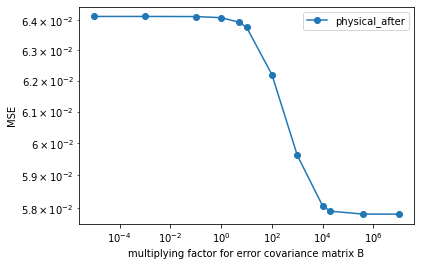

In [43]:
# plt.plot(val, mse_physical_before, label="physical_before")
# ax
ax = plt.axes()
ax.loglog(val, mse_physical_after,'-o', label="physical_after")

ax.set_xlabel("multiplying factor for error covariance matrix B")
ax.set_ylabel("MSE")
ax.legend()

## Experiment 2: Set B and R as a covariance matrix of the compressed data and vary the coefficient of B

In [44]:
# Initial set up
R = np.cov(satellite_data_compr.T)
B = np.cov(model_data_compr.T)

val = [0.00001, 0.001, 0.1, 1, 5, 100, 9999999]
mse_physical_before, mse_physical_after, mse_latent_before, mse_latent_after = data_assim_experiment(val, I, H, R, B, latent_space)

B:  1e-05 mse_l_bef:  187.19478449101607 mse_l_af:  489.99368203207564 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.17796680747895713
B:  0.001 mse_l_bef:  187.19478449101607 mse_l_af:  430.21121105090407 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.1633072945607839
B:  0.1 mse_l_bef:  187.19478449101607 mse_l_af:  40323.28193124836 
 mse_p_bef:  0.1191695914227833 mse_p_af:  9.945656133111052
B:  1 mse_l_bef:  187.19478449101607 mse_l_af:  374278.01537507784 
 mse_p_bef:  0.1191695914227833 mse_p_af:  91.83611078739854
B:  5 mse_l_bef:  187.19478449101607 mse_l_af:  13254987.24498127 
 mse_p_bef:  0.1191695914227833 mse_p_af:  3250.369377271397
B:  100 mse_l_bef:  187.19478449101607 mse_l_af:  32501566.45607169 
 mse_p_bef:  0.1191695914227833 mse_p_af:  7969.904584581325
B:  9999999 mse_l_bef:  187.19478449101607 mse_l_af:  508228.60701868334 
 mse_p_bef:  0.1191695914227833 mse_p_af:  124.68270271256041


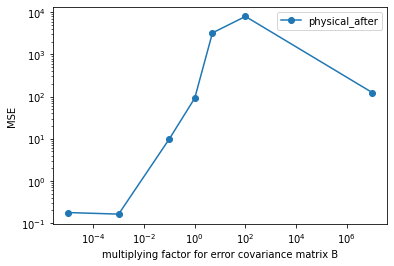

In [45]:
# plt.plot(val, mse_physical_before, label="physical_before")
# ax
ax = plt.axes()
ax.loglog(val, mse_physical_after,'-o', label="physical_after")

ax.set_xlabel("multiplying factor for error covariance matrix B")
ax.set_ylabel("MSE")
ax.legend()

## Experiment 3: Let R be compressed data and B be a diagonal matrix of a covariance matrix of the compressed data, vary B

In [46]:
# Initial set up
R = np.cov(satellite_data_compr.T)
B = da.covariance_diagonal_only(model_data_compr.T, latent_space)

val = [0.00001, 0.001, 0.1, 1, 5, 10, 100, 500, 1000, 5000, 9999999]
mse_physical_before, mse_physical_after, mse_latent_before, mse_latent_after = data_assim_experiment(val, I, H, R, B, latent_space)

B:  1e-05 mse_l_bef:  187.19478449101607 mse_l_af:  40.697560911152095 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06779300262348907
B:  0.001 mse_l_bef:  187.19478449101607 mse_l_af:  40.69712346148161 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06779289535460255
B:  0.1 mse_l_bef:  187.19478449101607 mse_l_af:  40.65344866792662 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.0677821856734902
B:  1 mse_l_bef:  187.19478449101607 mse_l_af:  40.262705158819365 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06768636980262642
B:  5 mse_l_bef:  187.19478449101607 mse_l_af:  38.64641203954306 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06729003172103312
B:  10 mse_l_bef:  187.19478449101607 mse_l_af:  36.84596545091647 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06684853658723768
B:  100 mse_l_bef:  187.19478449101607 mse_l_af:  19.791008081772365 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06266641825441394
B:  500 mse_l_bef:  187.19478449101607 mse_l_af:  4.473921885493125 
 mse_p

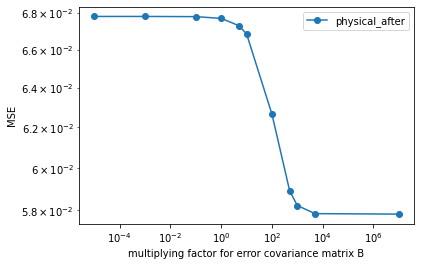

In [47]:
# plt.plot(val, mse_physical_before, label="physical_before")
# ax
ax = plt.axes()
ax.loglog(val, mse_physical_after,'-o', label="physical_after")

ax.set_xlabel("multiplying factor for error covariance matrix B")
ax.set_ylabel("MSE")
ax.legend()

## Experiment 4: Let B = I and vary R instead. Make R a diagonal covariance matrix of varying magnitude

In [48]:
# Initial set up
R = da.covariance_diagonal_only(satellite_data_compr.T, latent_space)
B = I

val = [0.1, 1, 5, 10, 100, 1000, 20000, 50000, 9999999]
mse_physical_before, mse_physical_after, mse_latent_before, mse_latent_after = data_assim_experiment(val, I, H, R, B, latent_space)

B:  0.1 mse_l_bef:  187.19478449101607 mse_l_af:  184.6343003661018 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.1030883401498372
B:  1 mse_l_bef:  187.19478449101607 mse_l_af:  171.23851316243224 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.0998035024317184
B:  5 mse_l_bef:  187.19478449101607 mse_l_af:  147.3370067855363 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.0939425128181198
B:  10 mse_l_bef:  187.19478449101607 mse_l_af:  132.507770916475 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.09030617308138311
B:  100 mse_l_bef:  187.19478449101607 mse_l_af:  63.700035686645975 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.07343353689025607
B:  1000 mse_l_bef:  187.19478449101607 mse_l_af:  18.821821796748576 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.06242875998047112
B:  20000 mse_l_bef:  187.19478449101607 mse_l_af:  0.48824191144210244 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.05793310520484867
B:  50000 mse_l_bef:  187.19478449101607 mse_l_af:  0.09120331153143711 
 mse

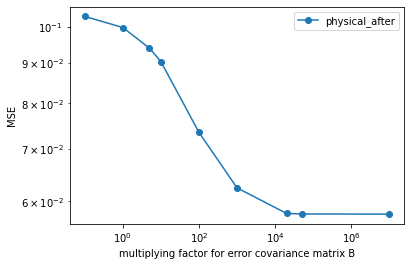

In [49]:
# plt.plot(val, mse_physical_before, label="physical_before")
# ax
ax = plt.axes()
ax.loglog(val, mse_physical_after,'-o', label="physical_after")

ax.set_xlabel("multiplying factor for error covariance matrix B")
ax.set_ylabel("MSE")
ax.legend()

## Experiment 5: fix R and B as covariance diagonal only and vary B

In [57]:
# Initial set up
R = da.covariance_diagonal_only(satellite_data_compr.T, latent_space)
B = da.covariance_diagonal_only(model_data_compr.T, latent_space)

val = [0.001, 0.1, 1, 5, 10, 20, 50, 1000]
mse_physical_before, mse_physical_after, mse_latent_before, mse_latent_after = data_assim_experiment(val, I, H, R, B, latent_space)

B:  0.001 mse_l_bef:  187.19478449101607 mse_l_af:  179.47758042287177 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.1018238390112511
B:  0.1 mse_l_bef:  187.19478449101607 mse_l_af:  60.65437481628186 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.07268669748832614
B:  1 mse_l_bef:  187.19478449101607 mse_l_af:  13.361457521210742 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.061089800929073124
B:  5 mse_l_bef:  187.19478449101607 mse_l_af:  3.40336873337252 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.05864793579988482
B:  10 mse_l_bef:  187.19478449101607 mse_l_af:  1.6775789576225701 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.058224747579384194
B:  20 mse_l_bef:  187.19478449101607 mse_l_af:  0.733824929912166 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.05799332565697553
B:  50 mse_l_bef:  187.19478449101607 mse_l_af:  0.1973903085935639 
 mse_p_bef:  0.1191695914227833 mse_p_af:  0.057861784251411155
B:  1000 mse_l_bef:  187.19478449101607 mse_l_af:  0.0008116902740867613 
 m

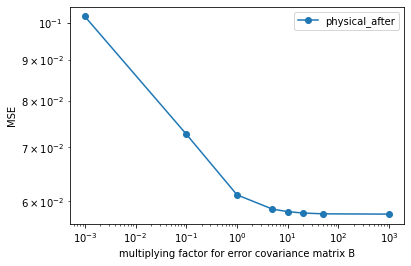

In [58]:
# plt.plot(val, mse_physical_before, label="physical_before")
# ax
ax = plt.axes()
ax.loglog(val, mse_physical_after,'-o', label="physical_after")

ax.set_xlabel("multiplying factor for error covariance matrix B")
ax.set_ylabel("MSE")
ax.legend()